# AutoML Marketting Campaign

In this assignment, you will an AutoML library like H2O.ai to create predictive models and interpret them. Find a significant relation for each algorithm of your choosing in your data. Create multivariate models.

For the moment you will assume the data is good. In future assignments, you will check your data, fix data issues and do some feature engineering. 

## About Dataset - Marketing Campaign

Dataset Link - https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

**Context**
A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses. The objective is to predict who will respond to an offer for a product or service

**Content**

1. AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
2. AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
3. AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
4. AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
5. AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
6. Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
7. Complain - 1 if customer complained in the last 2 years
8. DtCustomer - date of customer’s enrolment with the company
9. Education - customer’s level of education
10. Marital - customer’s marital status
11. Kidhome - number of small children in customer’s household
12. Teenhome - number of teenagers in customer’s household
13. Income - customer’s yearly household income
14. MntFishProducts - amount spent on fish products in the last 2 years
15. MntMeatProducts - amount spent on meat products in the last 2 years
16. MntFruits - amount spent on fruits products in the last 2 years
17. MntSweetProducts - amount spent on sweet products in the last 2 years
18. MntWines - amount spent on wine products in the last 2 years
19. MntGoldProds - amount spent on gold products in the last 2 years
20. NumDealsPurchases - number of purchases made with discount
21. NumCatalogPurchases - number of purchases made using catalogue
22. NumStorePurchases - number of purchases made directly in stores
23. NumWebPurchases - number of purchases made through company’s web site
24. NumWebVisitsMonth - number of visits to company’s web site in the last month
25. Recency - number of days since the last purchase

Answer the following questions for all of the models:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

* Coding professionalism?

In [32]:
#!pip3 install h2o

## Getting Clean Data from Previous assignment

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

data = pd.read_csv("https://raw.githubusercontent.com/makarandmadhavi/ML-Data-Cleaning-and-Feature-Selection/main/marketing_campaign.csv", sep=";")
data.drop(columns = ["Z_CostContact","Z_Revenue","ID",],inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In [34]:
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace = True)
data['Year_Birth'] = data['Year_Birth'].apply(lambda x: 2020-x)
data = data.rename(columns={'Year_Birth': 'Age'})

Education_map = {'Basic':1,
            'Graduation':2,
            'Master':3,
            '2n Cycle':3,
            'PhD':4}
# Create the mapped values in a new column
data['Education'] = data['Education'].map(Education_map)

from datetime import datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%Y-%m-%d')
data['Dt_Customer'] = (datetime(2020,1,1) - data['Dt_Customer']).dt.days

data['Children'] = data['Kidhome'] + data['Teenhome']
data.drop(columns = ["Kidhome","Teenhome"],inplace = True)

data['AmountSpent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
data.drop(columns = ["MntWines",	"MntFruits"	,"MntMeatProducts",	"MntFishProducts","MntSweetProducts",	"MntGoldProds"],inplace = True)

data['NumPurchased'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
data.drop(columns = ["NumWebPurchases",	"NumCatalogPurchases",	"NumStorePurchases"],inplace = True)

data['Prev_campaigns'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']
data.drop(columns = ["AcceptedCmp3",	"AcceptedCmp4",	"AcceptedCmp5",	"AcceptedCmp1",	"AcceptedCmp2"],inplace = True)

maratial_map = {'Married':"Couple",
            'Together':"Couple",
            'Single':'Single',
            'Divorced':'Single',
            'Widow':'Single',
            'Alone':'Single',
            'Absurd':'Single',
            'YOLO':'Single'}
# Create the mapped values in a new column
data['Marital_Status'] = data['Marital_Status'].map(maratial_map)

dummy_status = pd.get_dummies(data['Marital_Status'], prefix='Marital_Status')

data = pd.concat([data, dummy_status], axis=1)
data.drop(['Marital_Status'], axis=1, inplace=True)

data.head()

,Age,Education,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Complain,Response,Children,AmountSpent,NumPurchased,Prev_campaigns,Marital_Status_Couple,Marital_Status_Single
0,63,2,58138.0,2675,58,3,7,0,1,0,1617,22,0,0,1
1,66,2,46344.0,2125,38,2,5,0,0,2,27,4,0,0,1
2,55,2,71613.0,2324,26,1,4,0,0,0,776,20,0,1,0
3,36,2,26646.0,2151,26,2,6,0,0,1,53,6,0,1,0
4,39,4,58293.0,2173,94,5,5,0,0,1,422,14,0,1,0


In [35]:
data.Income.quantile(0.99)

94437.68000000001

In [36]:
data.drop(data[data['Income'] >= 93651].index, inplace = True)

In [37]:
data.isnull().sum()

Age                      0
Education                0
Income                   0
Dt_Customer              0
Recency                  0
NumDealsPurchases        0
NumWebVisitsMonth        0
Complain                 0
Response                 0
Children                 0
AmountSpent              0
NumPurchased             0
Prev_campaigns           0
Marital_Status_Couple    0
Marital_Status_Single    0
dtype: int64

In [38]:
from sklearn import preprocessing

# Create x to store scaled values as floats
x = data[["Age",	"Education",	"Income",	"Dt_Customer",	"Recency",	"NumDealsPurchases",	"NumWebVisitsMonth",	"Children",	"AmountSpent",	"NumPurchased",	"Prev_campaigns"]].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
data[["Age",	"Education",	"Income",	"Dt_Customer",	"Recency",	"NumDealsPurchases",	"NumWebVisitsMonth",	"Children",	"AmountSpent",	"NumPurchased",	"Prev_campaigns"]] = pd.DataFrame(x_scaled)

data.head()

,Age,Education,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Complain,Response,Children,AmountSpent,NumPurchased,Prev_campaigns,Marital_Status_Couple,Marital_Status_Single
0,0.378641,0.333333,0.615311,0.948498,0.585859,0.200000,0.35,0,1,0.000000,0.639683,0.6875,0.0,0,1
1,0.407767,0.333333,0.486659,0.161660,0.383838,0.133333,0.25,0,0,0.666667,0.008730,0.1250,0.0,0,1
2,0.300971,0.333333,0.762299,0.446352,0.262626,0.066667,0.20,0,0,0.000000,0.305952,0.6250,0.0,1,0
3,0.116505,0.333333,0.271789,0.198856,0.262626,0.133333,0.30,0,0,0.333333,0.019048,0.1875,0.0,1,0
4,0.145631,1.000000,0.617002,0.230329,0.949495,0.333333,0.25,0,0,0.333333,0.165476,0.4375,0.0,1,0


[Text(0, 0, 'Age'),
 Text(1, 0, 'Education'),
 Text(2, 0, 'Income'),
 Text(3, 0, 'Dt_Customer'),
 Text(4, 0, 'Recency'),
 Text(5, 0, 'NumDealsPurchases'),
 Text(6, 0, 'NumWebVisitsMonth'),
 Text(7, 0, 'Complain'),
 Text(8, 0, 'Response'),
 Text(9, 0, 'Children'),
 Text(10, 0, 'AmountSpent'),
 Text(11, 0, 'NumPurchased'),
 Text(12, 0, 'Prev_campaigns'),
 Text(13, 0, 'Marital_Status_Couple'),
 Text(14, 0, 'Marital_Status_Single')]

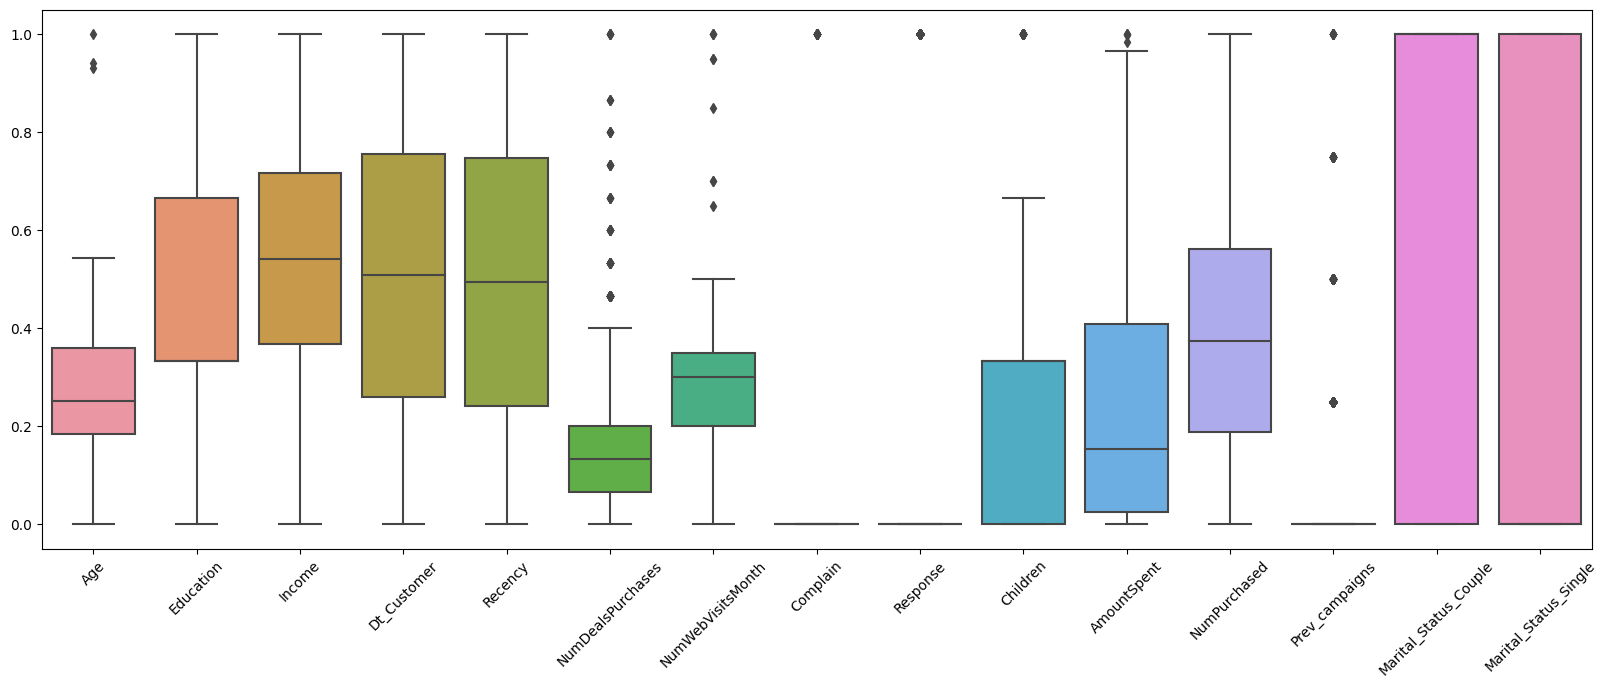

In [39]:
plt.figure(figsize=(20,7))
x = sns.boxplot(data=data)
x.set_xticklabels(x.get_xticklabels(),rotation=45)

# Initializing H20

In [40]:
#Importing required packages
import h2o
from h2o.automl import H2OAutoML

In [41]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 mins 21 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_makarandmadhavi_sx7l20
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.000 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [42]:
df = h2o.H2OFrame(data)
df.describe(chunk_summary=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:2214
Cols:15

Chunk compression summary: 
chunk_type    chunk_name        count    count_percentage    size     size_percentage
------------  ----------------  -------  ------------------  -------  -----------------
CBS           Binary            3        20                  1.0 KB   1.10284
CXI           Sparse Integers   1        6.66667             118  B   0.125009
C1S           1-Byte Fractions  1        6.66667             2.2 KB   2.4345
C4S           4-Byte Fractions  1        6.66667             8.7 KB   9.47104
CUD           Unique Reals      6        40                  28.0 KB  30.3582
C8D           64-bit Reals      3        20                  52.1 KB  56.5084

Frame distribution summary: 
                 size     number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  -------  ----------------  -----------------------------  ------------------
127.0.0.1:54321  92.2 KB  2214              1                              15
mean             92.2 KB  2214              1                              15
min              92.2 KB  2214              1                              15
max              92.2 KB  2214              1                              15
stddev           0  B     0                 0                              0
total            92.2 KB  2214              1                              15

,Age,Education,Income,Dt_Customer,Recency,NumDealsPurchases,NumWebVisitsMonth,Complain,Response,Children,AmountSpent,NumPurchased,Prev_campaigns,Marital_Status_Couple,Marital_Status_Single
type,real,real,real,real,real,real,real,int,int,real,real,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.26418500268331874,0.555047967108269,0.5404357829757822,0.5061802705816756,0.4956878054182759,0.1557484391655248,0.2676107811786203,0.009485094850948509,0.14498644986449866,0.3188670625856545,0.23545142741122646,0.39026096391046156,0.07103700319780737,0.6454381210478771,0.3545618789521229
maxs,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,0.11613273010151527,0.2794279071515558,0.22081840973902278,0.28902710491209654,0.292185905447644,0.12621569896116225,0.12026897868066563,0.0969503648918201,0.3521667163587916,0.24980970950439596,0.23585067651268604,0.22328255955042792,0.16397254474718884,0.4784884153133252,0.4784884153133252
zeros,2,53,1,2,28,30,7,2193,1893,612,1,4,1748,785,1429
missing,25,25,25,25,25,25,25,0,0,25,25,25,25,0,0
0,0.378640776699029,0.3333333333333333,0.6153107751379889,0.9484978540772536,0.5858585858585859,0.2,0.35000000000000003,0.0,1.0,0.0,0.6396825396825397,0.6875,0.0,0.0,1.0
1,0.40776699029126207,0.3333333333333333,0.4866592490782556,0.1616595135908443,0.38383838383838387,0.13333333333333333,0.25,0.0,0.0,0.6666666666666666,0.00873015873015873,0.125,0.0,0.0,1.0
2,0.30097087378640774,0.3333333333333333,0.7622990160787136,0.44635193133047224,0.26262626262626265,0.06666666666666667,0.2,0.0,0.0,0.0,0.305952380952381,0.625,0.0,1.0,0.0
